## Training an image classifier

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using torchvision
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

In [38]:
import torch
import torchvision
import torchvision.transforms as transforms

In [39]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(device)


cuda:2


In [40]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)

Files already downloaded and verified


In [41]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,shuffle=True,num_workers=8)

In [42]:
testset= torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)

Files already downloaded and verified


In [43]:
testloader = torch.utils.data.DataLoader(trainset, batch_size=100,shuffle=False,num_workers=8)

In [44]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [45]:
import matplotlib.pyplot as plt
import numpy as np

In [46]:
def imshow(img):
    img = img / 2 + 0.5 #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

In [47]:
#get some random training images
dataiter = iter(trainloader)
images,labels=dataiter.next()

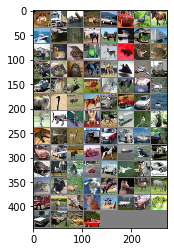

 frog truck truck  deer   car   car  bird horse  ship   cat  deer horse horse  bird truck truck truck   cat  bird  frog  deer   cat  frog  frog  bird  frog   cat   dog  deer plane plane truck   car   cat  deer plane   cat horse   cat   cat   dog  bird  bird horse   car   car   car  bird  bird plane truck   dog horse truck  bird  bird   dog  bird  deer   cat   car   car  ship  bird   car   car  deer truck horse  ship   dog truck  frog horse   cat   car truck plane   cat   car   cat   dog  deer   dog horse horse  deer horse truck  deer  bird   cat  ship plane   car  frog   car   car  deer   car


In [61]:
#show images
imshow(torchvision.utils.make_grid(images))
#print lables
print(' '.join('%5s' % classes[labels[j]] for j in range(100)))

## 2. Define a CNN:

In [49]:
import torch.nn as nn
import torch.nn.functional as F

In [50]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear (120,84)
        self.fc3 = nn.Linear(84,10)
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net().to(device)

## 3. Define a Loss function and optimizer

In [51]:
import torch.optim as optim

In [52]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

## 4. Train the network

In [55]:
for epoch in range(2):
    running_loss = 0.0
    for i,data in enumerate(trainloader,0):
        inputs, labels = data[0].to(device),data[1].to(device)
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss= criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 100 ==99:
            print('[%d,%5d] loss: %.3f' %
                 (epoch+1,i+1,running_loss /2000))
            running_loss = 0.0
print ('Finished Trainning')

[1,  100] loss: 0.098
[1,  200] loss: 0.097
[1,  300] loss: 0.096
[1,  400] loss: 0.095
[1,  500] loss: 0.093
[2,  100] loss: 0.092
[2,  200] loss: 0.091
[2,  300] loss: 0.090
[2,  400] loss: 0.090
[2,  500] loss: 0.089
Finished Trainning


In [56]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## 5. Test the network on the test data

In [76]:
dataiter = iter(testloader)
images, labels = dataiter.next()

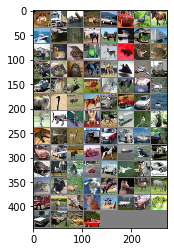

GroundTruth:   frog truck truck  deer   car   car  bird horse  ship   cat  deer horse horse  bird truck truck truck   cat  bird  frog  deer   cat  frog  frog  bird  frog   cat   dog  deer plane plane truck   car   cat  deer plane   cat horse   cat   cat   dog  bird  bird horse   car   car   car  bird  bird plane truck   dog horse truck  bird  bird   dog  bird  deer   cat   car   car  ship  bird   car   car  deer truck horse  ship   dog truck  frog horse   cat   car truck plane   cat   car   cat   dog  deer   dog horse horse  deer horse truck  deer  bird   cat  ship plane   car  frog   car   car  deer   car


In [77]:
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(100))) 

In [78]:
net = Net().to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [79]:
outputs = net (images.to(device))

In [80]:
_,predicted = torch.max(outputs,1)

In [83]:
print('Predicted: ',' '.join('%5s' % classes[predicted[j]]

                              for j in range(100)))

Predicted:   frog  ship truck  frog   car  frog   car horse plane horse  deer horse horse   car horse  ship truck   cat horse   car plane horse  frog  deer   car truck  frog horse truck  bird   car truck   car   dog  bird  deer plane horse  ship   car truck   dog horse horse   car   car   car plane   cat plane   car  frog horse  ship   cat truck  deer  frog  deer truck  ship  ship  ship   car   car   car  deer truck horse plane plane   car truck   car  bird  bird  ship   car horse plane truck  bird  frog  ship  bird  frog horse horse  deer truck   dog horse plane   car  ship  frog   car truck  frog  frog


In [88]:
## all the testset:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device),data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 36 %


In [90]:
## what are the classes that performed well, and the classes that did not perform well:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device),data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 51 %
Accuracy of   car : 39 %
Accuracy of  bird : 11 %
Accuracy of   cat : 23 %
Accuracy of  deer : 20 %
Accuracy of   dog : 26 %
Accuracy of  frog : 48 %
Accuracy of horse : 51 %
Accuracy of  ship : 41 %
Accuracy of truck : 48 %
